In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
import shapely

WGS_84 = 4326
CA_NAD83Albers_m = 3310

### Data intake

In [2]:
SIGNAL_DATA_PATH = "culver_city_signal_locations.csv"
STUDY_AREA_PATH = "city_boundary.geojson"

In [3]:
signals = pd.read_csv(SIGNAL_DATA_PATH)[
    [
        "TspAssetID",
        "Name",
        "Lat",
        "Long",
        "IPHostAddress",
    ]
].dropna(subset=["Lat", "Long"])
signal_gdf = gpd.GeoDataFrame(
    signals,
    geometry=gpd.points_from_xy(
        signals["Long"].astype(float), signals["Lat"], crs=WGS_84
    ),
)

In [4]:
# Buffer the boundary area, since there are some designated intersections just outside city limites
city_boundary = (
    gpd.read_file(STUDY_AREA_PATH)
    .to_crs(CA_NAD83Albers_m)
    .buffer(1000)
    .to_crs(WGS_84)
    .loc[0]
)

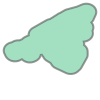

In [5]:
city_boundary

Get OSM street info

In [6]:
raw_osmnx = ox.graph.graph_from_polygon(
    city_boundary, network_type="drive_service", simplify=True, truncate_by_edge=True
)
simplified = ox.simplification.consolidate_intersections(
    ox.projection.project_graph(raw_osmnx, to_crs=CA_NAD83Albers_m),
)
streets_osmnx = ox.bearing.add_edge_bearings(
    ox.projection.project_graph(simplified, to_latlong=True)
)
# Remove edges without bearings - these are all loops, and we don't need to think about them!
streets_osmnx = streets_osmnx.edge_subgraph(
    [
        edge[0:3]
        for edge in streets_osmnx.edges(keys=True, data=True)
        if "bearing" in edge[3]
    ]
)

### Assign orientations to streets

In [7]:
EAST_WEST = 0
NORTH_SOUTH = 1
STREET_DIRECTIONS = {
    "Culver Boulevard": EAST_WEST,
    "Washington Boulevard": EAST_WEST,
    "West Washington Boulevard": EAST_WEST,
    "Washington Place": EAST_WEST,
    "Overland Avenue": NORTH_SOUTH,
    "Venice Boulevard": EAST_WEST,
    "Buckingham Parkway": NORTH_SOUTH,
    "Bristol Parkway": NORTH_SOUTH,
    "Hayden Avenue": NORTH_SOUTH,
    "Eastham Drive": NORTH_SOUTH,
    # "Higuera Street": EAST_WEST,
    "National Boulevard": EAST_WEST,
    "Jefferson Boulevard": EAST_WEST,
    # "Green Valley Circle": EAST_WEST,
    "West Slauson Avenue": EAST_WEST,
    "Sepulveda Boulevard": NORTH_SOUTH,
    "Hannum Avenue": EAST_WEST,
    "South Centinela Avenue": EAST_WEST,
    "Robertson Boulevard": NORTH_SOUTH,
    "Sawtelle Boulevard": NORTH_SOUTH,
}
STREET_NAMES = STREET_DIRECTIONS.keys()


def switch_orientation(orientation):
    assert orientation == EAST_WEST or orientation == NORTH_SOUTH
    return EAST_WEST if orientation == NORTH_SOUTH else NORTH_SOUTH

In [8]:
# Assign orientations and mark streets with transit
# graph_with_transit = streets_osmnx.edge_subgraph(keep_edges)
edges = streets_osmnx.edges(keys=True, data=True)
for name in STREET_NAMES:
    # Filter edges with matching names
    edges_with_matching_name = [edge for edge in edges if edge[3].get("name") == name]
    for edge in edges_with_matching_name:
        orientation = STREET_DIRECTIONS[name]
        streets_osmnx[edge[0]][edge[1]][edge[2]]["orientation"] = orientation
        streets_osmnx[edge[0]][edge[1]][edge[2]]["transit"] = True

### Extract intersections and edges with transit assigned to them

In [9]:
# Extract intersections near osm intersections with orientations
osm_intersections_gdf, osm_streets_gdf = ox.convert.graph_to_gdfs(streets_osmnx)
osm_intersections_nearest_signal = (
    signal_gdf.to_crs(CA_NAD83Albers_m)
    .sjoin_nearest(
        osm_intersections_gdf.to_crs(CA_NAD83Albers_m), how="left", max_distance=50
    )
    .dropna(subset=["x"])
)
signal_nodes_osmids = osm_intersections_nearest_signal["osmid"].values
# Extract in-edges to signalized intersections
signal_in_edges = streets_osmnx.in_edges(signal_nodes_osmids, keys=True, data=True)

### Assign upper and lower bounds

In [10]:
def positive_distance_to_bearing(b1, b2):
    if b2 > b1:
        return b2 - b1
    else:
        return (360 - b1) + b2


def negative_distance_to_bearing(b1, b2):
    if b1 > b2:
        return b1 - b2
    else:
        return b1 + (360 - b2)


def distance_to_bearing(b1, b2):
    return min(
        positive_distance_to_bearing(b1, b2), negative_distance_to_bearing(b1, b2)
    )

In [11]:
graph_with_bounds = streets_osmnx.copy()
# assign bounds to edges at all nodes
# assign orientations to all in edges with transit
for edge in signal_in_edges:
    # get other edges into the nodle
    edges_to_update = []
    destination_node_id = edge[1]
    other_edges_at_node = [
        other_edge
        for other_edge in graph_with_bounds.in_edges(
            destination_node_id, data=True, keys=True
        )
        if not nx.utils.edges_equal([edge], [other_edge])
    ]
    # assign upper and lower bearing bounds based on other edges
    bearing = edge[3]["bearing"]
    positive_distance_to_other_edge = [
        positive_distance_to_bearing(bearing, other_edge[3]["bearing"])
        for other_edge in other_edges_at_node
    ]
    negative_distance_to_other_edge = [
        negative_distance_to_bearing(bearing, other_edge[3]["bearing"])
        for other_edge in other_edges_at_node
    ]
    bearing_upper_bound = (bearing + min(positive_distance_to_other_edge) / 2) % 360
    bearing_lower_bound = (bearing - min(negative_distance_to_other_edge) / 2) % 360
    # add bearings to transit edge
    edge[3]["bearing_lower_bound"] = bearing_lower_bound.round(0)
    edge[3]["bearing_upper_bound"] = bearing_upper_bound.round(0)
    edges_to_update.append(edge)
    # add orientation to intersecting edges
    if "orientation" in edge[3]:
        edges_to_add_orientation = [
            other_edge
            for other_edge in other_edges_at_node
            if other_edge[3].get("orientation") is None
        ]
        for other_edge in edges_to_add_orientation:
            other_edge[3]["orientation"] = switch_orientation(edge[3]["orientation"])
            edges_to_update.append(other_edge)
    # update the graph
    graph_with_bounds.update(edges=edges_to_update)

In [12]:
# Get graph with actual non-absolute directions (N/S/E/W)

# This shows "canonical directions" in the jurisdiction, and varies for different jurisdictions based on the orientation of their street grid
# In Culver City, this is based on the Venice & Overland intersection
CANONICAL_DIRECTIONS = {
    "EAST": 30,
    "WEST": 215,
    "NORTH": 320,
    "SOUTH": 140,
}
CANONICAL_DIRECTION_TO_ORIENTATION = {
    "EAST": EAST_WEST,
    "WEST": EAST_WEST,
    "NORTH": NORTH_SOUTH,
    "SOUTH": NORTH_SOUTH,
}
CANONICAL_DIRECTION_TO_OPPOSITE_DIRECTION = {"EAST": "WEST", "NORTH": "SOUTH"}

DataKeyEdge = tuple[int, int, int, dict]


def assign_directions_single_orientation(
    results_tuples: list[tuple[DataKeyEdge, float, float]],
    direction_1: str,
    direction_2: str,
) -> tuple[DataKeyEdge | None, DataKeyEdge | None]:
    """
    Assign directions to edges

    Parameters:
    results_tuples: A list of tuples containing (in order) an edge, the absolute difference between the edge and direction_1 and the absolute difference between the edge and direction_2
    direction_1: A string with the name of the first direction
    direction_2: A string with the name of the second direction
    """
    # If there's only one tuple, assign the direction it's closest to
    if len(results_tuples) == 1:
        result = results_tuples[0]
        edge = tuple(result[0])
        edge[3]["direction"] = direction_1 if result[1] < result[2] else direction_2
        return edge, None
    # If there's two tuples, first assign a direction to the one that's closest to a canonical direciton, then assign the other direction to the other one
    elif len(results_tuples) == 2:
        closest_result, second_closest_result = tuple(
            sorted(results_tuples, key=lambda x: min(x[1:3]))
        )
        closest_edge = tuple(closest_result[0])
        second_closest_edge = tuple(second_closest_result[0])
        closest_edge[3]["direction"] = (
            direction_1 if closest_result[1] < closest_result[2] else direction_2
        )
        second_closest_edge[3]["direction"] = (
            direction_1 if closest_edge[3]["direction"] == direction_2 else direction_2
        )
        return closest_edge, second_closest_edge
    # If there's more than two tuples, this isn't defined, return None
    return None, None


# Get a graph with all edges that have assigned orientations, these are the ones where we need to assign edges
"""graph_with_directions = graph_with_bounds.edge_subgraph(
    [
        (u, v, k)
        for u, v, k, data in graph_with_bounds.in_edges(keys=True, data=True)
        if data.get("transit")
    ]
).copy()"""

edges_to_update = []
nodes_to_update = []
for node in graph_with_bounds.nodes(data=True):
    # Assign directions to edges
    edges = [
        edge
        for edge in graph_with_bounds.in_edges(node[0], keys=True, data=True)
        if "orientation" in edge[3]
    ]
    edges_to_update_north_south = [
        (
            edge,
            distance_to_bearing(edge[3]["bearing"], CANONICAL_DIRECTIONS["NORTH"]),
            distance_to_bearing(edge[3]["bearing"], CANONICAL_DIRECTIONS["SOUTH"]),
        )
        for edge in edges
        if edge[3]["orientation"] == NORTH_SOUTH
    ]
    edges_to_update_east_west = [
        (
            edge,
            distance_to_bearing(edge[3]["bearing"], CANONICAL_DIRECTIONS["EAST"]),
            distance_to_bearing(edge[3]["bearing"], CANONICAL_DIRECTIONS["WEST"]),
        )
        for edge in edges
        if edge[3]["orientation"] == EAST_WEST
    ]
    north_south_edge1, north_south_edge2 = assign_directions_single_orientation(
        edges_to_update_north_south, "NORTH", "SOUTH"
    )
    east_west_edge1, east_west_edge2 = assign_directions_single_orientation(
        edges_to_update_east_west, "EAST", "WEST"
    )
    for edge in (
        north_south_edge1,
        north_south_edge2,
        east_west_edge1,
        east_west_edge2,
    ):
        if edge is not None:
            # Update edges
            edges_to_update.append(edge)
            # Assign bearings to the node for each direction
            bearing_lower_bound = edge[3].get("bearing_lower_bound")
            bearing_upper_bound = edge[3].get("bearing_upper_bound")
            if bearing_lower_bound is not None and bearing_upper_bound is not None:
                direction_column_name_lower = f"{edge[3]['direction'].lower()}_min"
                direction_column_name_upper = f"{edge[3]['direction'].lower()}_max"
                assert (
                    direction_column_name_lower not in node[1]
                ), "lower bearing repeated?"
                assert (
                    direction_column_name_upper not in node[1]
                ), "upper bearing repeated?"
                node[1][direction_column_name_lower] = bearing_lower_bound
                node[1][direction_column_name_upper] = bearing_upper_bound
                # Update node
                nodes_to_update.append(node)
graph_with_bounds.update(edges_to_update)

### Get tabular output

In [13]:
osm_nodes, osm_streets_into_signals = ox.convert.graph_to_gdfs(graph_with_bounds)

In [14]:
# Assign osm nodes to signal ids
osm_nodes_with_signal_ids = (
    osm_nodes.to_crs(CA_NAD83Albers_m)
    .sjoin_nearest(
        signal_gdf[[signal_gdf.geometry.name, "TspAssetID", "Name"]].to_crs(
            CA_NAD83Albers_m
        ),
        max_distance=50,
        how="right",
    )
    .drop_duplicates(subset=["TspAssetID"])
)

In [15]:
# Export nodes with signal ids
bearing_columns = [
    "north_min",
    "north_max",
    "south_min",
    "south_max",
    "east_min",
    "east_max",
    "west_min",
    "west_max",
]
assert not osm_nodes_with_signal_ids["TspAssetID"].duplicated(keep=False).any()
nodes_with_signal_ids_reindexed = osm_nodes_with_signal_ids.set_index("TspAssetID")
nodes_with_signal_ids_reindexed[["osmid", "Name", "x", "y", *bearing_columns]].to_csv(
    "signals_with_bearings.csv"
)

### Compare with bus headings

The below tables compare the reported heading data with bus headings submitted by Culver City

In [16]:
TSP_HEADING_PATH = "culver_city_tsp_headings.csv"
validation_headings = pd.read_csv(TSP_HEADING_PATH)
validation_headings["TspAssetID"] = (
    validation_headings["Intersection"].str.slice(13).astype(int)
)
validation_headings["direction"] = (
    validation_headings["Route Direction"].str.split(" ", expand=True)[0].str.lower()
)

In [17]:
# Reformat the data with bearings to match the validation data (bus headings)
nodes_with_signal_ids_long = (
    nodes_with_signal_ids_reindexed.reset_index()
    .melt(
        id_vars=["TspAssetID", "geometry"],
        value_vars=bearing_columns,
        var_name="bearing_type",
        value_name="bearing",
    )
    .drop_duplicates()
    .dropna(subset=["TspAssetID"])
)
nodes_with_signal_ids_long[["direction", "type"]] = nodes_with_signal_ids_long[
    "bearing_type"
].str.split("_", expand=True)
# node_with_signal_ids_long.pivot(columns=["type"], index=["TspAssetID"], values=["direction", "bearing"])
nodes_with_signal_ids_matching_validation = (
    nodes_with_signal_ids_long.drop("bearing_type", axis=1)
    .dropna(subset=["bearing"])
    .pivot(index=["TspAssetID", "direction", "geometry"], columns=["type"])
)
nodes_with_signal_ids_matching_validation.columns = (
    nodes_with_signal_ids_matching_validation.columns.droplevel()
)
nodes_with_signal_ids_matching_validation.reset_index(
    level=["geometry"], inplace=True
)  # TODO - inplace bad?
nodes_with_signal_ids_matching_validation = gpd.GeoDataFrame(
    nodes_with_signal_ids_matching_validation, geometry="geometry"
)

This table shows rows where the reported heading is not within the bounds specified by the heading ranges. In these cases, manual correction is likely required. 

The success rate is the proportion of intersections where there are headings and no error compared to the proportion of intersections where there are headings

In [18]:
# Get signals where bus headings do not match reported headings
nodes_validation_merged = nodes_with_signal_ids_matching_validation.merge(
    validation_headings[
        ["TspAssetID", "Heading", "direction", "Route", "Intersection", "Name"]
    ].drop_duplicates(),
    how="outer",
    left_index=True,
    right_on=["TspAssetID", "direction"],
    validate="one_to_many",
).reset_index(drop=True)
nodes_validation_merged["error"] = (
    nodes_validation_merged["Heading"].notna()
    & nodes_validation_merged["max"].notna()
    & nodes_validation_merged["min"].notna()
    & ~(nodes_validation_merged["Heading"] > nodes_validation_merged["min"])
    & ~(nodes_validation_merged["Heading"] < nodes_validation_merged["max"])
)
nodes_validation_merged["success"] = (
    ~nodes_validation_merged["error"]
    & nodes_validation_merged["Heading"].notna()
    & nodes_validation_merged["max"].notna()
    & nodes_validation_merged["min"].notna()
)
nodes_validation_merged["heading_available"] = nodes_validation_merged[
    "Heading"
].notna()
print(
    f"Success Rate:  {(nodes_validation_merged['success'] & nodes_validation_merged['heading_available']).sum() / nodes_validation_merged['heading_available'].sum()}"
)
nodes_validation_merged.loc[nodes_validation_merged["error"]]

Success Rate:  0.8507042253521127


,geometry,max,min,TspAssetID,Heading,direction,Route,Intersection,Name,error,success,heading_available
150,POINT (147546.815 -443380.648),87.0,357.0,34,110.0,east,Rt1C1,Intersection 34,Culver Blvd + Overland Ave,True,False,True
161,POINT (147968.769 -442732.958),88.0,348.0,37,300.0,east,Rt5,Intersection 37,Culver Blvd + Madison Ave,True,False,True
299,POINT (148545.638 -447128.217),28.0,249.0,61,200.0,west,Rt2,Intersection 61,Centinela Ave + Bristol Pkway,True,False,True
301,POINT (148676.569 -446728.956),72.0,339.0,62,105.0,north,Rt3,Intersection 62,Bristol Pkwy + Green Valley Cir,True,False,True
310,POINT (149455.506 -446276.501),47.0,309.0,64,80.0,north,Rt3,Intersection 64,Hannum Ave + Buckingham Pkwy,True,False,True
313,POINT (149248.172 -446295.124),43.0,311.0,65,80.0,north,Rt3,Intersection 65,Hannum Ave + Uplander Way,True,False,True
317,POINT (149049.532 -446129.55),43.0,314.0,66,250.0,north,Rt3,Intersection 66,Slauson Ave + Bristol Pkway,True,False,True
328,POINT (148134.554 -446904.543),47.0,227.0,69,125.0,north,Rt3,Intersection 69,Centinela Ave + Radisson Hotel Dwy,True,False,True
332,POINT (148235.285 -446975.169),71.0,327.0,70,195.0,south,Rt3,Intersection 70,Centinela Ave + Arizona Ave,True,False,True
336,POINT (148325.554 -447017.35),85.0,327.0,71,120.0,north,Rt3,Intersection 71,Sepulveda Blvd + Centinela Ave,True,False,True


This table shows all places where there are headings, but where the heading is not between the max and min. This may be due to an error, or because a max or min were not produced.

In [19]:
nodes_validation_merged.loc[
    nodes_validation_merged["heading_available"] & ~nodes_validation_merged["success"]
]

,geometry,max,min,TspAssetID,Heading,direction,Route,Intersection,Name,error,success,heading_available
150,POINT (147546.815 -443380.648),87.0,357.0,34,110.0,east,Rt1C1,Intersection 34,Culver Blvd + Overland Ave,True,False,True
161,POINT (147968.769 -442732.958),88.0,348.0,37,300.0,east,Rt5,Intersection 37,Culver Blvd + Madison Ave,True,False,True
205,None,NaN,NaN,45,35.0,east,Rt1,Intersection 45,Cardiff Ave + Culver Blvd,False,False,True
206,None,NaN,NaN,45,35.0,east,Rt5,Intersection 45,Cardiff Ave + Culver Blvd,False,False,True
207,None,NaN,NaN,45,35.0,east,Rt7,Intersection 45,Cardiff Ave + Culver Blvd,False,False,True
208,None,NaN,NaN,45,35.0,east,Rt1C1,Intersection 45,Cardiff Ave + Culver Blvd,False,False,True
224,None,NaN,NaN,47,35.0,east,Rt1,Intersection 47,Culver Blvd + Canfield Ave / Washington Blvd,False,False,True
225,None,NaN,NaN,47,35.0,east,Rt5,Intersection 47,Culver Blvd + Canfield Ave / Washington Blvd,False,False,True
226,None,NaN,NaN,47,35.0,east,Rt7,Intersection 47,Culver Blvd + Canfield Ave / Washington Blvd,False,False,True
227,None,NaN,NaN,47,35.0,east,Rt1C1,Intersection 47,Culver Blvd + Canfield Ave / Washington Blvd,False,False,True


In [20]:
nodes_validation_merged["success"].value_counts()

success
True     302
False    194
Name: count, dtype: int64

In [21]:
nodes_validation_merged.loc[
    ~nodes_validation_merged["success"]
    & nodes_validation_merged["heading_available"]
    & ~nodes_validation_merged["error"],
    ["Name", "TspAssetID", "geometry"],
].drop_duplicates()

,Name,TspAssetID,geometry
205,Cardiff Ave + Culver Blvd,45,None
224,Culver Blvd + Canfield Ave / Washington Blvd,47,None
266,Washington Blvd + National Bl/Exposition Bl,54,None
297,Centinela Ave + Bristol Pkway,61,None
314,Hannum Ave + Uplander Way,65,None
318,Slauson Ave + Bristol Pkway,66,None
341,Sepulveda Blvd + Green Valley Cir,72,None
350,Sepulveda Blvd + Westfield Mall Dwy,73,None
363,Slauson Ave + Hannum Ave,76,None
383,Slauson Ave + Jefferson Blvd/Playa Pacific Dwy,79,None


In [22]:
nodes_validation_merged.loc[nodes_validation_merged["TspAssetID"] == 8]

,geometry,max,min,TspAssetID,Heading,direction,Route,Intersection,Name,error,success,heading_available
33,POINT (145230.28 -444896.856),104.0,14.0,8,NaN,east,NaN,NaN,NaN,False,False,False
34,POINT (145230.28 -444896.856),14.0,283.0,8,NaN,north,NaN,NaN,NaN,False,False,False
35,POINT (145230.28 -444896.856),193.0,104.0,8,NaN,south,NaN,NaN,NaN,False,False,False
36,POINT (145230.28 -444896.856),283.0,193.0,8,NaN,west,NaN,NaN,NaN,False,False,False


### Manual Validation (maps)

There are two options here - to load an altered file (the next cell), or to use the calculated version (the one after). Comment out the one you don't want

In [24]:
# load corrected polys instead - this should usually be commented out
corrected_output = pd.read_csv("signals_with_bearings_round_1_corrections.csv")
gdf_corrected_output = gpd.GeoDataFrame(
    corrected_output,
    geometry=gpd.points_from_xy(corrected_output["x"], corrected_output["y"], crs=WGS_84),
).rename(columns={"Name": "name"}).to_crs(CA_NAD83Albers_m)
common_columns = ["name", "x", "y", "geometry"]
corrected_output_formatted = pd.concat(
    [
        gdf_corrected_output[["north_min", "north_max", *common_columns]].assign(
            direction="north"
        ).rename(columns={"north_min": "bearing_lower_bound", "north_max": "bearing_upper_bound"}),
        gdf_corrected_output[["south_min", "south_max", *common_columns]].assign(
            direction="south"
        ).rename(columns={"south_min": "bearing_lower_bound", "south_max": "bearing_upper_bound"}),
        gdf_corrected_output[["east_min", "east_max", *common_columns]].assign(
            direction="east"
        ).rename(columns={"east_min": "bearing_lower_bound", "east_max": "bearing_upper_bound"}),
        gdf_corrected_output[["west_min", "west_max", *common_columns]].assign(
            direction="west"
        ).rename(columns={"west_min": "bearing_lower_bound", "west_max": "bearing_upper_bound"}),
    ],
    axis=0
).dropna(subset=["bearing_lower_bound", "bearing_upper_bound"])
corrected_output_formatted["origin_point"] = corrected_output_formatted["geometry"]
# OVERRIDES EVERYTHING BEFORE THIS
osm_validation_polys = corrected_output_formatted

,bearing_lower_bound,bearing_upper_bound,name,x,y,geometry,direction,origin_point
1,282.0,12.0,Washington Blvd + Glencoe Ave / Costco Dwy,-118.444767,33.991958,POINT (143688.03 -445880.502),north,POINT (143688.03 -445880.502)
2,282.0,11.0,Washington Blvd + Redwood Ave,-118.442336,33.993209,POINT (143910.367 -445738.081),north,POINT (143910.367 -445738.081)
3,283.0,12.0,Washington Blvd + Beethoven St,-118.438212,33.995256,POINT (144287.612 -445504.753),north,POINT (144287.612 -445504.753)
4,281.0,25.0,Washington Blvd + Rosabell St,-118.436049,33.996241,POINT (144485.595 -445392.222),north,POINT (144485.595 -445392.222)
6,284.0,18.0,Washington Pl + Centinela Ave,-118.430342,33.999425,POINT (145006.904 -445030.388),north,POINT (145006.904 -445030.388)
...,...,...,...,...,...,...,...,...
98,170.0,260.0,Culver Blvd + I-405 NB On Off Ramps,-118.410907,34.003361,POINT (146794.913 -444563.892),west,POINT (146794.913 -444563.892)
99,183.0,323.0,National Blvd + Eastham Dr,-118.377610,34.026752,POINT (149826.033 -441917.582),west,POINT (149826.033 -441917.582)
100,186.0,265.0,Washington Blvd + McLaughlin Ave,-118.417695,33.999996,POINT (146174.113 -444947.649),west,POINT (146174.113 -444947.649)
101,166.0,317.0,Jefferson Blvd + Hetzler Rd (New),-118.382557,34.020507,POINT (149381.072 -442617.982),west,POINT (149381.072 -442617.982)


In [25]:
"""# default version, using the calculated streets
osm_validation_polys = (
    osm_streets_into_signals.copy()
    .to_crs(CA_NAD83Albers_m)
    .dropna(subset=["bearing_lower_bound", "bearing_upper_bound"])
)

osm_validation_polys["origin_point"] = osm_validation_polys["geometry"].map(
    lambda geom: shapely.get_point(geom, -1)
)"""

'# default version, using the calculated streets\nosm_validation_polys = (\n    osm_streets_into_signals.copy()\n    .to_crs(CA_NAD83Albers_m)\n    .dropna(subset=["bearing_lower_bound", "bearing_upper_bound"])\n)\n\nosm_validation_polys["origin_point"] = osm_validation_polys["geometry"].map(\n    lambda geom: shapely.get_point(geom, -1)\n)'

In [26]:
# draw validation polys
DRAW_DISTANCE = 100

osm_validation_polys["lower_bound_point_x"] = (
    -1 * DRAW_DISTANCE * np.sin(np.radians(osm_validation_polys["bearing_lower_bound"]))
    + osm_validation_polys["origin_point"].x
)
osm_validation_polys["lower_bound_point_y"] = (
    -1 * DRAW_DISTANCE * np.cos(np.radians(osm_validation_polys["bearing_lower_bound"]))
    + osm_validation_polys["origin_point"].y
)
osm_validation_polys["upper_bound_point_x"] = (
    -1 * DRAW_DISTANCE * np.sin(np.radians(osm_validation_polys["bearing_upper_bound"]))
    + osm_validation_polys["origin_point"].x
)
osm_validation_polys["upper_bound_point_y"] = (
    -1 * DRAW_DISTANCE * np.cos(np.radians(osm_validation_polys["bearing_upper_bound"]))
    + osm_validation_polys["origin_point"].y
)
origin_coords = list(
    zip(osm_validation_polys["origin_point"].x, osm_validation_polys["origin_point"].y)
)
lower_bound_coords = list(
    zip(
        osm_validation_polys["lower_bound_point_x"],
        osm_validation_polys["lower_bound_point_y"],
    )
)
upper_bound_coords = list(
    zip(
        osm_validation_polys["upper_bound_point_x"],
        osm_validation_polys["upper_bound_point_y"],
    )
)
validation_linearring = shapely.linearrings(
    list(
        zip(
            origin_coords,
            lower_bound_coords,
            upper_bound_coords,
        )
    )
)
osm_validation_polys["polygon_geometry"] = gpd.GeoSeries(
    shapely.polygons(validation_linearring),
    crs=CA_NAD83Albers_m,
    index=osm_validation_polys.index,
)
osm_validation_polys = osm_validation_polys.set_geometry("polygon_geometry")

In [28]:
# Draw request distance rows
REQUEST_DISTANCE = 182  # 600 feet in meters
gdf_validation_headings = gpd.GeoDataFrame(
    validation_headings.merge(
        signal_gdf[["TspAssetID", signal_gdf.geometry.name]],
        how="left",
        on="TspAssetID",
        validate="many_to_one",
    ),
    geometry=signal_gdf.geometry.name,
).to_crs(CA_NAD83Albers_m)
gdf_validation_headings["end_x"] = (
    gdf_validation_headings.geometry.x
    - REQUEST_DISTANCE * np.sin(np.radians(gdf_validation_headings["Heading"]))
)
gdf_validation_headings["end_y"] = (
    gdf_validation_headings.geometry.y
    - REQUEST_DISTANCE * np.cos(np.radians(gdf_validation_headings["Heading"]))
)
origin_coords = list(
    zip(gdf_validation_headings.geometry.x, gdf_validation_headings.geometry.y)
)
end_coords = list(
    zip(gdf_validation_headings["end_x"], gdf_validation_headings["end_y"])
)
heading_linestrings = shapely.linestrings(list(zip(origin_coords, end_coords)))
gdf_validation_headings["line_geometry"] = gpd.GeoSeries(
    heading_linestrings, crs=CA_NAD83Albers_m, index=gdf_validation_headings.index
)
heading_linestrings = gdf_validation_headings.set_geometry("line_geometry")

In [29]:
m = osm_validation_polys[
    [
        "name",
        "bearing_lower_bound",
        "bearing_upper_bound",
        "direction",
        osm_validation_polys.geometry.name,
    ]
].explore("direction")
"""osm_streets_into_signals.loc[
    ~osm_streets_into_signals.orientation.isna(),
    ["name", "direction", "bearing", osm_streets_into_signals.geometry.name],
].explore("direction", m=m)"""
m = heading_linestrings.explore("direction", m=m)
output_map = osm_nodes_with_signal_ids[
    ["TspAssetID", "Name", *bearing_columns, osm_nodes_with_signal_ids.geometry.name]
].explore(m=m, marker_kwds={"radius": 4})
output_map.save("output_map.html")
output_map